<a href="https://colab.research.google.com/github/ParkWonjeong/Limitless/blob/main/Limitless_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 비트코인 시장 관련 데이터 분석

# Part 1. 시간적 특성 분석
### 비트코인은 언제 움직이는가?

비트코인 시장은 365일 24시간 열려있지만, 전 세계 투자자들의 활동 시간은 정해져있을 것이라고 생각됩니다. 요일과 시간대별로 수익률과 변동성이 어떻게 다른지 분석하여, 트레이딩 봇이 가장 유리한 시간대에 매매하고 위험한 시간대를 피할 수 있도록 돕는 근거를 마련하고자 합니다.




*   가설 1: 미국 증시 개장 시간에 변동성이 가장 클 것이다.
*   가설 2: 주말과 같은 특정 요일에는 거래량이 줄어들며, 수익률 패턴에서 평일과 차이가 발생할 것이다.



#### 수익률 히트맵

/tmp/ipython-input-2209575933.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_raw = yf.download("BTC-USD", period = "2y", interval = "1h")
[*********************100%***********************]  1 of 1 completed


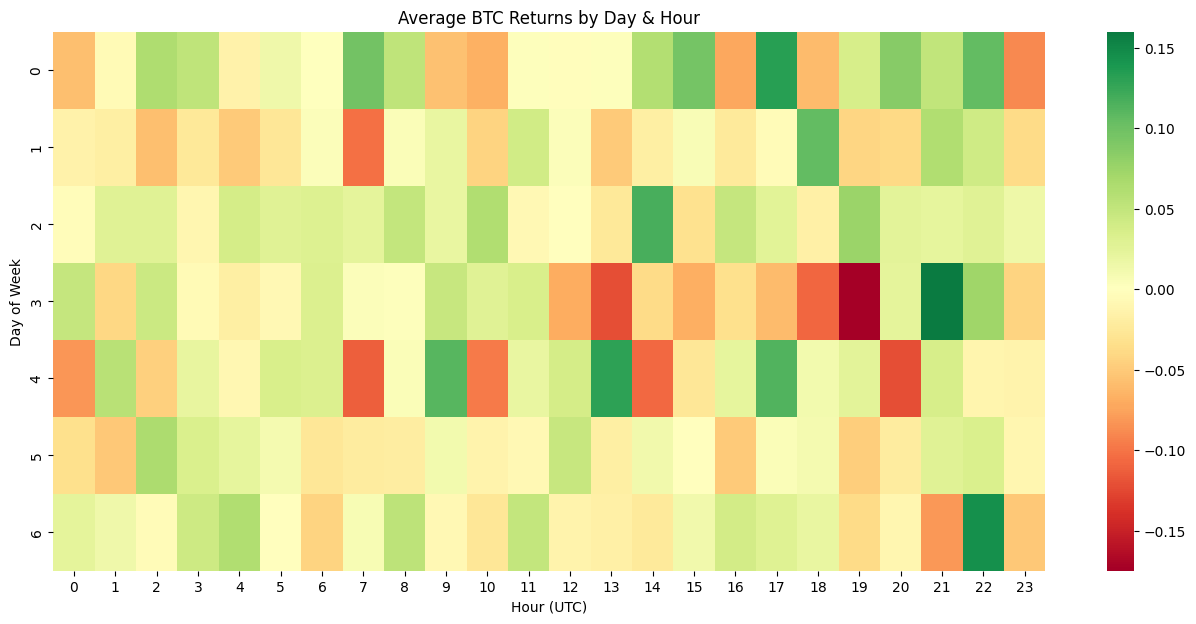

In [1]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 불러오기 (최근 2년치 1시간 봉)
df_raw = yf.download("BTC-USD", period = "2y", interval = "1h")
# 다중 인덱스 처리
if isinstance(df_raw.columns, pd.MultiIndex):
  df_raw.columns = df_raw.columns.get_level_values(0)

# 분석용 데이터프레임 만들기
df_ana = df_raw.copy()
df_ana['hour'] = df_ana.index.hour
df_ana['day_of_week'] = df_ana.index.dayofweek
df_ana['returns'] = df_ana['Close'].pct_change() * 100

# 요일별/시간별 평균 수익률 히트맵 계산
pivot_table = df_ana.pivot_table(values = 'returns',
                                 index = 'day_of_week',
                                 columns = 'hour',
                                 aggfunc = 'mean')


# 히트맵 시각화
plt.figure(figsize = (16, 7))
sns.heatmap(pivot_table, cmap = 'RdYlGn', center = 0)
plt.title('Average BTC Returns by Day & Hour')
plt.xlabel('Hour (UTC)')
plt.ylabel('Day of Week')
plt.show()



*   초록색: 해당 요일, 해당 시간에 평균적으로 가격이 많이 올랐음 (수익 구간)
*   빨간색: 해당 요일, 해당 시간에 평균적으로 가격이 많이 내렸음 (손실 구간)
*   노란색/흰색: 가격 변화가 거의 없는 구간





1.   변동성 집중: UTC 13시~22시 사이에 색깔이 가장 진하게 변함.
2.   요일별 특징: 목요일 오후는 전반적으로 색이 강함. 그에 반해 토요일이나 밤을 제외한 일요일과 같은 주말은 옅은 것으로 보아, 주말과 평일의 차이가 존재한다고 생각해볼 수 있음
3.   결론: 위 결과를 토대로 봤을 때, 목요일 오후에는 매매를 지양하는 것을 고려해볼 필요가 있음

#### 변동성 히트맵

/tmp/ipython-input-420250507.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_raw = yf.download("BTC-USD", period = "2y", interval = "1h")
[*********************100%***********************]  1 of 1 completed


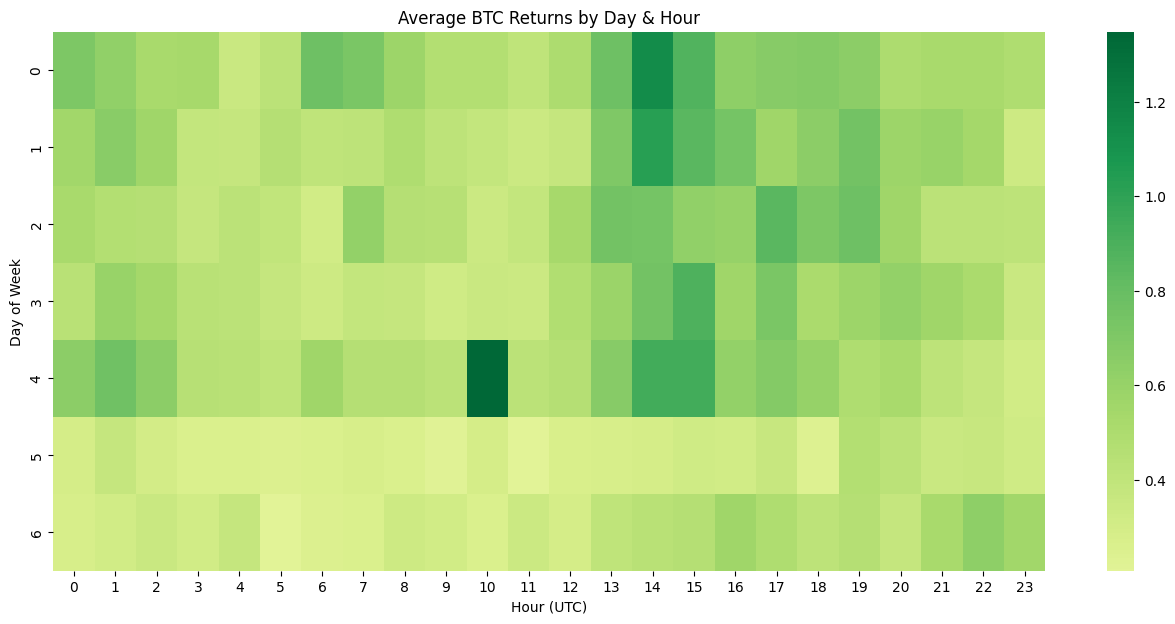

In [2]:
# 데이터 불러오기 (최근 2년치 1시간 봉)
df_raw = yf.download("BTC-USD", period = "2y", interval = "1h")
# 다중 인덱스 처리
if isinstance(df_raw.columns, pd.MultiIndex):
  df_raw.columns = df_raw.columns.get_level_values(0)

# 분석용 데이터프레임 만들기
df_ana = df_raw.copy()
df_ana['hour'] = df_ana.index.hour
df_ana['day_of_week'] = df_ana.index.dayofweek
df_ana['returns'] = df_ana['Close'].pct_change() * 100

# 요일별/시간별 평균 수익률 히트맵 계산
pivot_table = df_ana.pivot_table(values = 'returns',
                                 index = 'day_of_week',
                                 columns = 'hour',
                                 aggfunc = 'std')


# 히트맵 시각화
plt.figure(figsize = (16, 7))
sns.heatmap(pivot_table, cmap = 'RdYlGn', center = 0)
plt.title('Average BTC Returns by Day & Hour')
plt.xlabel('Hour (UTC)')
plt.ylabel('Day of Week')
plt.show()

변동성의 경우, 평일 오후, 특히 월요일과 금요일 14:00~16:00 사이의 변동성이 상당히 높은 것을 확인할 수 있음   
나아가 주말에는 평일보다 전반적인 색이 연하므로, 수익률 히트맵과 마찬가지로 평일과 주말의 차이를 보여주고 있음

# Part 2. 기술적 지표의 유효성 검증

다양한 기술적 지표가 있는데, 어떤 기술적 지표가 실질적인 매수 신호로서 가치가 있는지 검증하고, 비슷한 지표를 분류하여 불필요한 요소를 최대한 제거하기 위한 목적으로 분석합니다.

기술적 지표를 네 가지 카테고리로 분류하여 접근하였습니다.



1.   추세 지표 (Trend Indicators)   
-    시장의 방향 (상승, 하락, 횡보)   
2.   모멘텀 지표 (Momentum Indicators)   
-    현재 가격 움직임의 속도와 강도
3.   변동성 지표 (Volatility Indicators)   
-    가격이 얼마나 격렬하게 움직이는지의 범위   
4.   거래량 지표 (Volume Indicators)   
-    자금의 흐름 확인   



## Part 2-1. 지표간 상관관계 분석

*   항목 추가
*   항목 추가




In [3]:
!pip install pandas-ta

/tmp/ipython-input-3096224648.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_corr = yf.download("BTC-USD", period = "2y", interval = "1h")
[*********************100%***********************]  1 of 1 completed


수익률과의 상관계수 순위
Target_Return    1.000000
ATR_Pct          0.023569
RSI              0.000228
OBV_Change      -0.002303
Trend_Gap       -0.008244
Name: Target_Return, dtype: float64


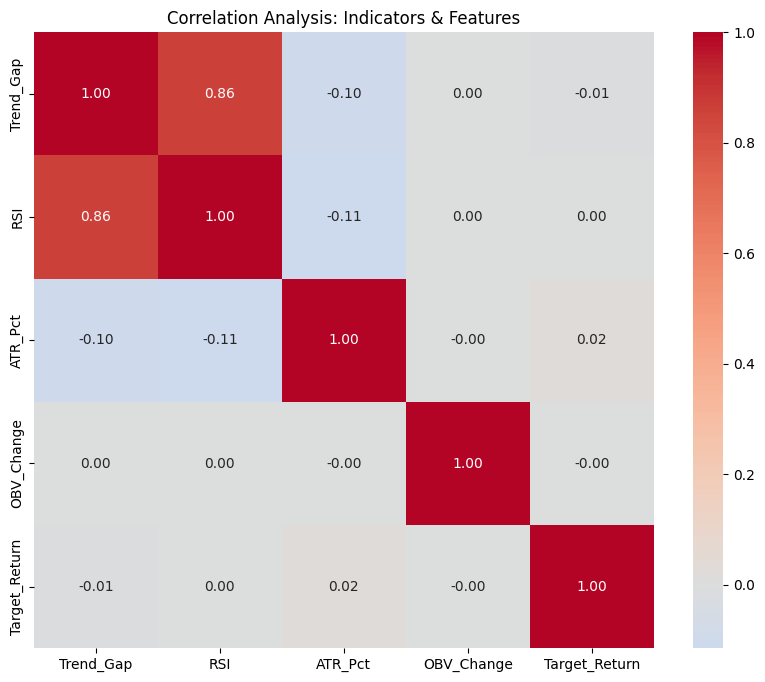

In [4]:
import pandas_ta as ta

# 데이터 준비
df_corr = yf.download("BTC-USD", period = "2y", interval = "1h")
df_corr.columns = [col[0]
                   if isinstance(col, tuple)
                   else col
                   for col
                   in df_corr.columns]

# 4개의 카테고리 대표 지표 계산
# 1. 추세: 이동평규넛ㄴ 괴리율 (현재가와 20일선의 차이)
df_corr['MA20'] = ta.sma(df_corr['Close'], length = 20)
df_corr['Trend_Gap'] = (df_corr['Close'] - df_corr['MA20']) / df_corr['MA20']

# 2. 모멘텀: RSI
df_corr['RSI'] = ta.rsi(df_corr['Close'], length = 14)

# 3. 변동성: ATR (상대적 변동성을 위해 종가로 나눔)
df_corr['ATR_Pct'] = ta.atr(df_corr['High'],
                            df_corr['Low'],
                            df_corr['Close'],
                            length = 14) / df_corr['Close']

# 4. 거래량: OBV (변화율로 변환하여 스케일 조정)
df_corr['OBV_Change'] = ta.obv(df_corr['Close'],
                               df_corr['Volume']).pct_change()

# 5. 타겟: 1시간 후의 수익률 (예측하고자 하는 결과값)
df_corr['Target_Return'] = df_corr['Close'].pct_change().shift(-1) * 100

# 결측치 제거
df_analysis = df_corr[['Trend_Gap',
                       'RSI',
                       'ATR_Pct',
                       'OBV_Change',
                       'Target_Return']].dropna()

# 상관관계 행렬 계산
corr_matrix = df_analysis.corr()

# 히트맵 시각화
plt.figure(figsize = (10, 8))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f', center = 0)
plt.title('Correlation Analysis: Indicators & Features')

# 상관계수 순위 출력
print("수익률과의 상관계수 순위")
print(corr_matrix['Target_Return'].sort_values(ascending=False))

전반적으로 지표의 상관계수의 절댓값이 작은 편으로 판단됩니다.   
그렇기에 개별 지표가 미세하게나마 방향성을 제시하고 있다고 생각해볼 수는 있지만 하나의 지표를 토대로 수익률을 예측하는 것은 상당히 위험하다고 생각해볼 수 있습니다.


이렇게 개별 지표가 선형성이 부족하다는 것은 확인할 수 이 있었지만, 완전히 버리는 것이 아니라 구간별로 나누어 비선형적인 특성을 반영하도록 지표를 더욱 세분화하거나 합쳐가며 비교해볼 필요가 있다고 생각됩니다.


## Part 2-2. RSI 구간별 기대 수익률 분석



1.   데이터 등분: RSI를 쪼개어 10개의 그룹을 만듭니다.
2.   라벨링
3.   통계 산출: 각 그룹별로 1시간 뒤의 평균 수익률을 계산합니다.



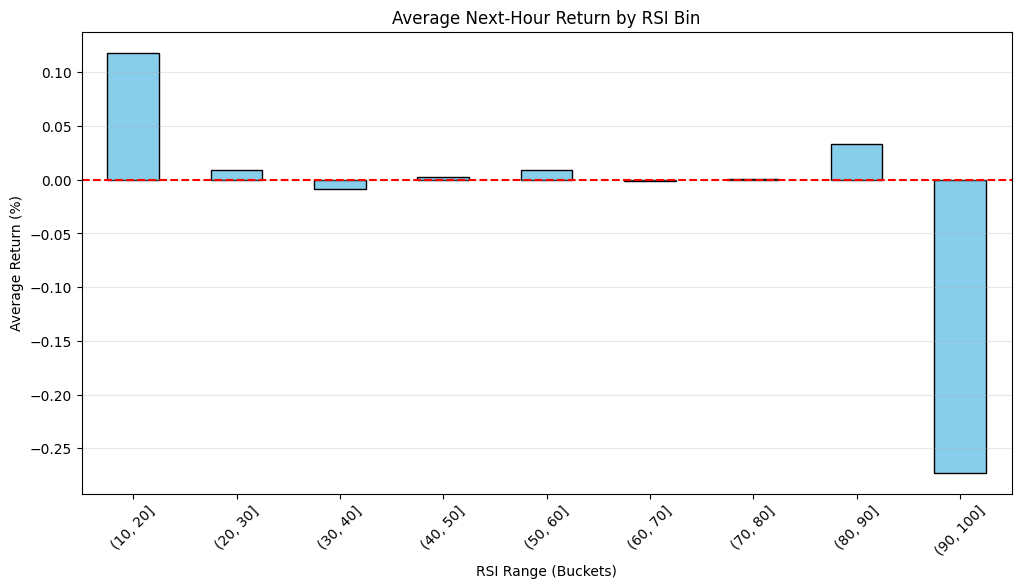

구간별 샘플 개수
RSI_Bin
(0, 10]         0
(10, 20]      100
(20, 30]      724
(30, 40]     2282
(40, 50]     5102
(50, 60]     5382
(60, 70]     2750
(70, 80]      906
(80, 90]      139
(90, 100]       2
Name: count, dtype: int64


In [5]:
# 데이터 준비 및 RSI 게산
df_bin = df_raw.copy()
df_bin['RSI'] = ta.rsi(df_bin['Close'], length = 14)
df_bin['Target_Return'] = df_bin['Close'].pct_change().shift(-1) * 100
df_bin = df_bin.dropna()

# RSI를 10개 구간으로 나누기
df_bin['RSI_Bin'] = pd.cut(df_bin['RSI'], bins = range(0, 101, 10))

# 구간별 평균 수익률 계산
bin_analysis = df_bin.groupby('RSI_Bin')['Target_Return'].mean()

# 시각화
plt.figure(figsize = (12, 6))
bin_analysis.plot(kind='bar', color='skyblue', edgecolor='black')
plt.axhline(0, color='red', linestyle='--') # 0선 기준 (수익/손실 경계)
plt.title('Average Next-Hour Return by RSI Bin')
plt.xlabel('RSI Range (Buckets)')
plt.ylabel('Average Return (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

# 구간 별 데이터 개수 확인
print("구간별 샘플 개수")
print(df_bin['RSI_Bin'].value_counts().sort_index())

(90, 100]의 구간에서 급격히 낮은 수익률을 보이는 것처럼 보이지만 샘플 개수가 2개 뿐이기에 유의성이 높은 결과라고는 할 수 없습니다.   

하지만 (10, 20]의 구간에서는 샘플 개수가 100개인데 상당히 높은 수익률을 보이므로, RSI가 (10, 20] 사이의 값 정도일때 평균 수익률이 유의미하게 상승하는 경향을 보인다고 생각해볼 수 있습니다.